# 2. Data preparation

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import pandas as pd

original: pd.DataFrame = pd.read_csv('../heart_failure_clinical_records_dataset_after_profiling.csv', sep=';')

cols_nr = original.select_dtypes(include='number')
cols_sb = original.select_dtypes(include='bool')

original.describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000


## 2.0. Data preparation

---

### Missing Values Imputation

---

In our dataset there are no missing values and therefore this step is not appliable.

In [2]:
df_nr = cols_nr
df_sb = cols_sb

### Outliers Imputation

---

In [3]:
# TODO

### Scaling

---

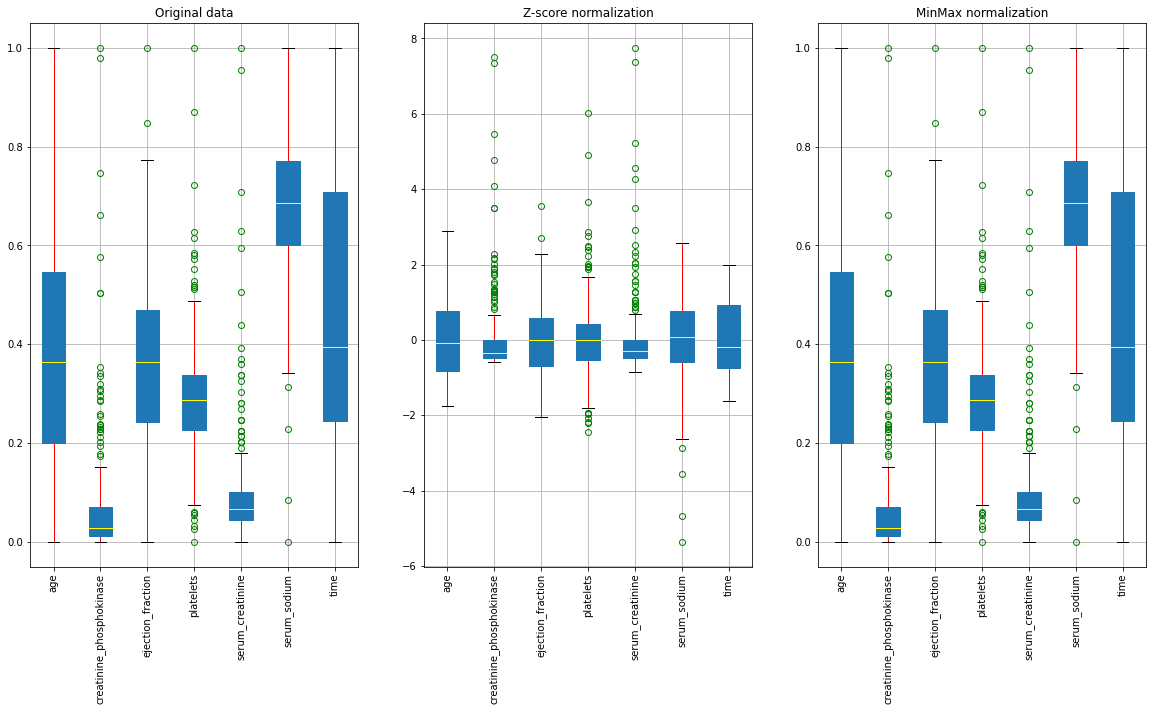

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_zscore = df_nr

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = df_nr

import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows = 1, ncols=3, figsize=(20, 10),squeeze=False)
axs[0, 0].set_title('Original data')
df_nr.boxplot(ax=axs[0, 0], rot=90, patch_artist=True, whiskerprops=dict(color='red'), medianprops=dict(color='yellow'), flierprops=dict(color='green', markeredgecolor='green'))
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1], rot=90, patch_artist=True, whiskerprops=dict(color='red'), medianprops=dict(color='yellow'), flierprops=dict(color='green', markeredgecolor='green'))
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2], rot=90, patch_artist=True, whiskerprops=dict(color='red'), medianprops=dict(color='yellow'), flierprops=dict(color='green', markeredgecolor='green'))
plt.show()

In [5]:
# Rejoin numeric with symbolic variables
norm_data_zscore = norm_data_zscore.join(df_sb, how='right')
norm_data_minmax = norm_data_minmax.join(df_sb, how='right')

### Splits

---

In [6]:
import numpy as np

ndm_copy = norm_data_minmax.copy(deep = True)

target = 'DEATH_EVENT'
positive = True
negative = False
values = {'Original': [len(ndm_copy[ndm_copy[target] == positive]), 
                       len(ndm_copy[ndm_copy[target] == negative])]}

y: np.ndarray = ndm_copy.pop(target).values
X: np.ndarray = ndm_copy.values
labels: np.ndarray = pd.unique(y)

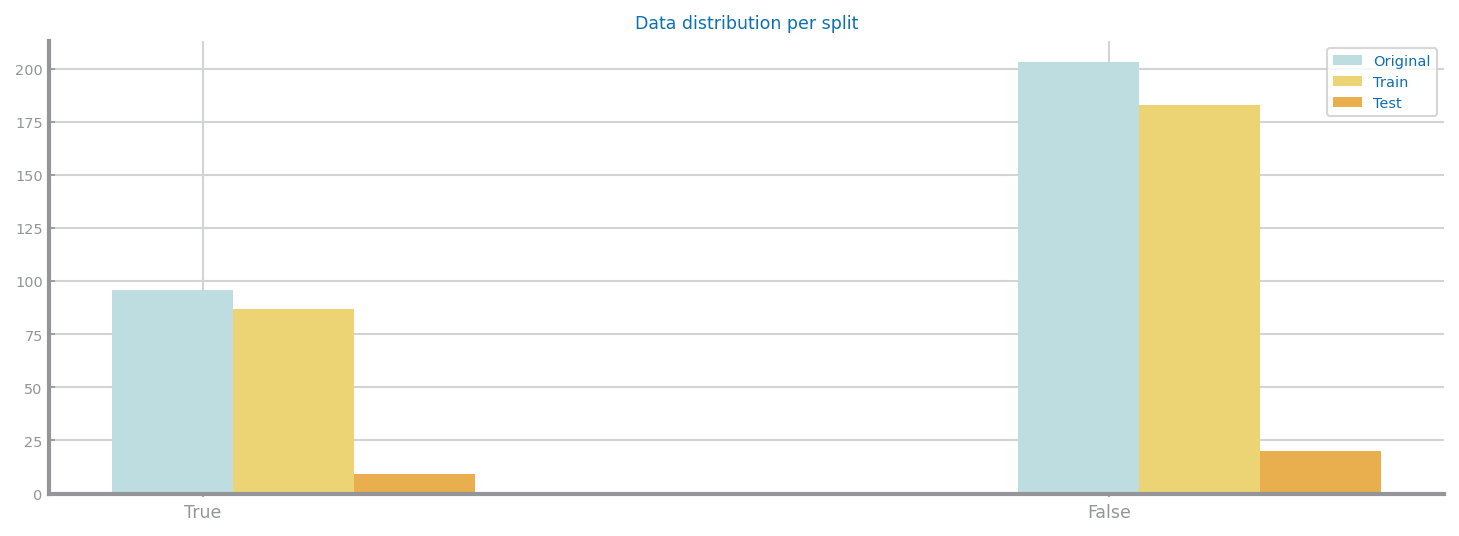

In [7]:
from sklearn.model_selection import StratifiedKFold
import ds_functions as ds

np.random.seed(1)
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X, y)

splits=[]

for train_index, test_index in skf.split(X, y):
    splits.append({'X_train': X[train_index], 'X_test': X[test_index],
                  'y_train': y[train_index], 'y_test': y[test_index]})

values['Train'] = [len(np.delete(y[train_index], np.argwhere(y[train_index]==negative))), len(np.delete(y[train_index], np.argwhere(y[train_index]==positive)))]
values['Test'] = [len(np.delete(y[test_index], np.argwhere(y[test_index]==negative))), len(np.delete(y[test_index], np.argwhere(y[test_index]==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels=True)
plt.show()

### Data balancing

---

In [8]:
# Convert splits to dataframes
columnsX = list(norm_data_minmax.columns)
columnsX.remove(target)

for split in splits:
    split['X_train'] = pd.DataFrame(data=split['X_train'], columns=columnsX)
    split['y_train'] = pd.DataFrame(data=split['y_train'], columns=[target])
    split['X_test'] = pd.DataFrame(data=split['X_test'], columns=columnsX)
    split['y_test'] = pd.DataFrame(data=split['y_test'], columns=[target])

firstData = pd.concat([splits[0]['X_train'], splits[0]['y_train']], axis = 1)

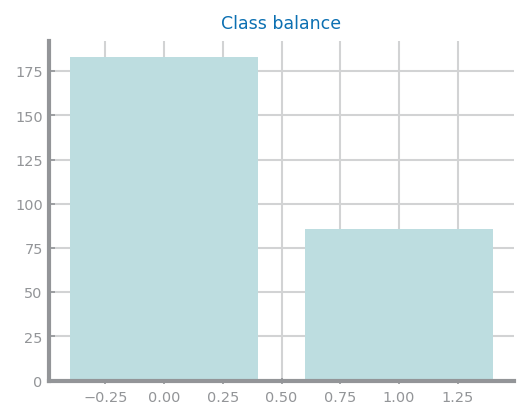

Minority class: 86
Majority class: 183
Proportion: 0.47 : 1


In [9]:
import matplotlib.pyplot as plt

target_count = firstData['DEATH_EVENT'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 3), ': 1')

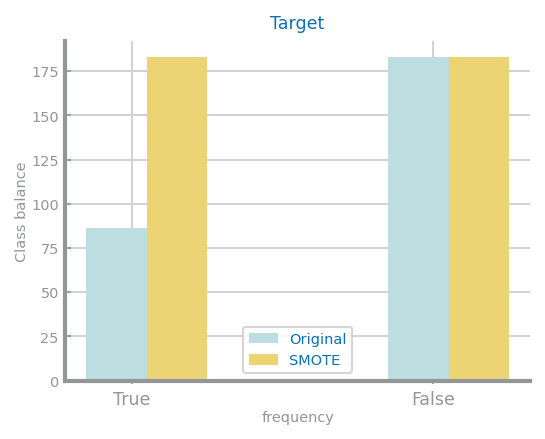

In [10]:
import ds_functions as ds
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)

smote_X = [None] * len(splits)
smote_y = [None] * len(splits)

for spli in range(len(splits)):
    split = splits[spli]
    y = split['y_train'].values
    X = split['X_train'].values
    smote_X[spli], smote_y[spli] = smote.fit_sample(X, y)

smote_target_count = pd.Series(smote_y[0]).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance', showXTickLabels=True)
plt.show()

In [11]:
smote_data = [None] * len(splits)
train_data = [None] * len(splits)

for spli in range(len(splits)):
    split = splits[spli]
    smote_data[spli] = pd.DataFrame(np.concatenate([smote_X[spli], smote_y[spli][:,None]], axis=1), columns=norm_data_minmax.columns)
    
    train_data[spli] = pd.concat((split['X_train'], split['y_train']), axis = 1)
    test_data = pd.concat((split['X_test'], split['y_test']), axis = 1)
    
    
    # Finally, export prepared data to csv
    train_data[spli].to_csv('data/prepared/%d.csv' % spli, sep=';', index=False)
    smote_data[spli].to_csv('data/prepared_b/%d.csv' % spli, sep=';', index=False)
    test_data.to_csv('data/prepared_test/%d.csv' % spli, sep=';', index=False)

### Feature Selection

---

#### Unsupervised Selection

By definition, unsupervised selection only aims for eliminating redundancies among the
variables, getting the smallest set possible.

In [12]:
import seaborn as sns
import numpy as np

y_list = [{'smote': None, 'train': None} for _ in range(len(splits))]
X_list = [{'smote': None, 'train': None} for _ in range(len(splits))]

for spli in range(len(splits)):
    data_dict = {'smote': smote_data[spli], 'train': train_data[spli]}
    for key in data_dict:
        df = data_dict[key]
        
        copy = df.copy(deep=True)
        copy = copy.drop('DEATH_EVENT', axis = 1)
        corr_mtx_copy = copy.corr()

        removed = []

        for x in corr_mtx_copy:
            for y in corr_mtx_copy:
                if x == y:
                    break
                corr = corr_mtx_copy[x][y]
                if abs(corr) >= 0.8 and x not in removed and y not in removed:
                    copy = copy.drop(x, axis=1)
                    removed.append(x)
                    break

        copy['DEATH_EVENT'] = df['DEATH_EVENT']
        if key == 'smote':
            smote_data[spli] = copy.copy()
        else:
            train_data[spli] = copy.copy()
        y_list[spli][key] = copy['DEATH_EVENT'].values
        X_list[spli][key] = copy.drop('DEATH_EVENT', axis=1).values

#### Supervised Selection


In the context of supervised selection, the goal is to identify the most relevant variables
in relation to the target variable, and so we need criteria able to relate each variable
with the target one.
We will use sequential backward selection to select our sets of variables.

In [13]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

bestSets = [{'smote': None, 'train': None} for _ in range(len(splits))]

for spli in range(len(splits)):
    print('Split %d' % spli)
    for key in ('smote', 'train'):
        y = y_list[spli][key]
        X = X_list[spli][key]
        
        bestAvgScore = 0
        bestSets[spli][key] = None
        bestNeighbors = -1

        for n_neighbors in range(1, 13):
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)

            sbfs = SFS(knn,
                       k_features=12,
                       forward=True,
                       floating=False,
                       scoring='accuracy',
                       cv=10,
                       n_jobs=-1)
            sbfs = sbfs.fit(X, y, custom_feature_names=copy.drop('DEATH_EVENT', axis=1).columns)

            for subset in sbfs.subsets_:
                if (sbfs.subsets_[subset]['avg_score'] > bestAvgScore):
                    bestAvgScore = sbfs.subsets_[subset]['avg_score']
                    bestSets[spli][key] = sbfs.subsets_[subset]['feature_names']
                    bestNeighbors = n_neighbors
        
        print(key.upper() + ':')
        print('Best Set:', bestSets[spli][key])
        print('Accuracy:', bestAvgScore)
        print('Nº neighbors:', bestNeighbors)
        print('---')

Split 0
SMOTE:
Best Set: ('age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'time', 'smoking')
Accuracy: 0.8777777777777779
Nº neighbors: 1
---
TRAIN:
Best Set: ('age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_sodium', 'time')
Accuracy: 0.8358974358974358
Nº neighbors: 5
---
Split 1
SMOTE:
Best Set: ('ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia')
Accuracy: 0.867042042042042
Nº neighbors: 3
---
TRAIN:
Best Set: ('ejection_fraction', 'time', 'anaemia')
Accuracy: 0.8433048433048432
Nº neighbors: 10
---
Split 2
SMOTE:
Best Set: ('age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'high_blood_pressure', 'sex')
Accuracy: 0.8834834834834835
Nº neighbors: 1
---
TRAIN:
Best Set: ('ejection_fraction', 'serum_creatinine', 'time', 'anaemia')
Accuracy: 0.8284900284900285
Nº neighbors: 9
---
Split 3
SMOTE:
Best Set: ('age', 'ejection_fraction', 'platelets', 

In [18]:
for spli in range(len(splits)):
    for key in ('smote', 'train'):
        final_data = smote_data[spli] if key == 'smote' else train_data[spli]
        
        for feature in norm_data_minmax.columns:
            if feature not in bestSets[spli][key] and feature != 'DEATH_EVENT':
                final_data = final_data.drop(feature, axis=1)
                
        folder = 'b_s' if key == 'smote' else 's'
        final_data.to_csv('data/prepared_%s/%d.csv' % (folder, spli), sep=';', index=False)

### Summary

---

***Are all variables in the same scale? If not, how does scaling impact the results?***

No, the numeric variables have different scales. After applying scaling, the results (with Naive Bayes algorithm) were similar, but slightly worse. After removing the outliers, the results were slightly better.

***Is the dataset unbalanced? If yes, what is the best balancing technique to apply?***

Yes, the dataset is unbalanced. To balance it we used SMOTE, an oversampling technique.